Importing the required lib

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2- Read csv file

In [62]:
df=pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')


3- Understand dataset dimensions and column types so we can plan cleaning/transformations.

In [63]:
print(df.head())
print(df.info())
print(df.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

4- Display null values in columns

In [64]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [65]:
print("\nNumeric summary:")
display(df.describe(include='number').T)

print("\nNon-numeric summary (sample):")
display(df.describe(include='object').T)


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0



Non-numeric summary (sample):


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


5-Convert datatypes & add helpful columns

In [66]:
# Make a copy of the original dataframe
df_clean = df.copy()
df_clean.columns = df_clean.columns.str.strip()

In [67]:
# Make a copy to preserve raw if needed
df_clean = df.copy()

# 1) Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

# 2) Convert numeric columns explicitly
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
df_clean['UnitPrice'] = pd.to_numeric(df_clean['UnitPrice'], errors='coerce')

# 3) Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 4) Inspect new dtypes and NaNs introduced
print(df_clean[['InvoiceDate','Quantity','UnitPrice','TotalPrice']].info())
display(df_clean[['InvoiceDate','Quantity','UnitPrice','TotalPrice']].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceDate  541909 non-null  datetime64[ns]
 1   Quantity     541909 non-null  int64         
 2   UnitPrice    541909 non-null  float64       
 3   TotalPrice   541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 16.5 MB
None


,InvoiceDate,Quantity,UnitPrice,TotalPrice
0,2010-12-01 08:26:00,6,2.55,15.30
1,2010-12-01 08:26:00,6,3.39,20.34
2,2010-12-01 08:26:00,8,2.75,22.00
3,2010-12-01 08:26:00,6,3.39,20.34
4,2010-12-01 08:26:00,6,3.39,20.34


6 Remove obvious bad rows and handle cancellations

In [70]:
# 1) Remove rows with all-null important fields (Description and InvoiceDate maybe)
initial_rows = df_clean.shape[0]

# Remove rows with InvoiceDate missing (can't analyze time series)
df_clean = df_clean[~df_clean['InvoiceDate'].isna()]

# Remove rows with Quantity or UnitPrice missing
df_clean = df_clean[~(df_clean['Quantity'].isna() | df_clean['UnitPrice'].isna())]

# 2) Remove negative or zero UnitPrice if they are obviously invalid (but we may examine returns separately)
# We'll keep negative quantities (returns) but optionally filter them in revenue-only views.
# For now remove rows where UnitPrice <= 0 or Quantity == 0 (zero-quantity transactions are suspicious)
df_clean = df_clean[df_clean['UnitPrice'] > 0]
df_clean = df_clean[df_clean['Quantity'] != 0]

# 3) Handle cancellations (InvoiceNo starting with 'C' often indicates cancellations)
# Create a flag
df_clean['IsCanceled'] = df_clean['InvoiceNo'].astype(str).str.startswith('C')

print(f"Rows before cleaning: {initial_rows}, after basic cleaning: {df_clean.shape[0]}")
print("Sample canceled rows (if any):")
display(df_clean[df_clean['IsCanceled']].head())



Rows before cleaning: 539392, after basic cleaning: 539392
Sample canceled rows (if any):


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,IsCanceled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,True


7 Handle duplicates and missing CustomerID (why: accurate customer-level analysis)

In [71]:
# 1) Duplicates
dupes = df_clean.duplicated()
print("Duplicate rows count:", dupes.sum())
# If duplicates exist, inspect a few and decide to drop exact duplicates
if dupes.sum() > 0:
    display(df_clean[dupes].head())
    df_clean = df_clean.drop_duplicates()

# 2) Missing CustomerID: many retail datasets miss guest purchases; decide treatment
missing_cust = df_clean['CustomerID'].isna().sum()
total = df_clean.shape[0]
print(f"Missing CustomerID: {missing_cust} of {total} rows ({missing_cust/total:.2%})")

# Option: create a placeholder or drop depending on analysis
# We'll create a placeholder string for missing customers to keep them in product/country analyses
df_clean['CustomerID'] = df_clean['CustomerID'].fillna(-1).astype(int)




Duplicate rows count: 5263


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,IsCanceled
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25,False
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10,False
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom,2.95,False
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95,False
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom,2.95,False


Missing CustomerID: 132565 of 534129 rows (24.82%)


Feature engineering (why: create analysis-ready fields)

In [72]:
# 1) Extract date parts for aggregations
df_clean['InvoiceYear'] = df_clean['InvoiceDate'].dt.year
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.month
df_clean['InvoiceDay'] = df_clean['InvoiceDate'].dt.date
df_clean['InvoiceHour'] = df_clean['InvoiceDate'].dt.hour
df_clean['InvoiceMonthName'] = df_clean['InvoiceDate'].dt.strftime('%b')

# 2) Create Order-level aggregation id if necessary (some InvoiceNo repeats for multi-row orders)
# Example: revenue per invoice
invoice_revenue = df_clean.groupby('InvoiceNo')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice':'InvoiceRevenue'})

# 3) Merge invoice_revenue back if needed
df_clean = df_clean.merge(invoice_revenue, on='InvoiceNo', how='left')

# Show sample
display(df_clean.head())


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,IsCanceled,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceMonthName,InvoiceRevenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,False,2010,12,2010-12-01,8,Dec,139.12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False,2010,12,2010-12-01,8,Dec,139.12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,False,2010,12,2010-12-01,8,Dec,139.12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False,2010,12,2010-12-01,8,Dec,139.12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False,2010,12,2010-12-01,8,Dec,139.12


Basic univariate & bivariate EDA (why: understand distributions and relationships)

In [ ]:
import matplotlib.pyplot as plt

# 1) Top 10 countries by revenue
country_rev = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).reset_index()
print(country_rev.head(10))

# 2) Top 20 products by revenue
prod_rev = df_clean.groupby(['StockCode','Description'])['TotalPrice'].sum().sort_values(ascending=False).reset_index().head(20)
print(prod_rev)

# 3) Sales over time (monthly)
monthly_sales = df_clean.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()
print(monthly_sales.head())
# Plot (matplotlib)
plt.figure(figsize=(12,5))
monthly_sales.plot()
plt.title('Monthly Revenue')
plt.ylabel('Total Revenue')
plt.xlabel('Month')
plt.show()

# 4) Quantity distribution (simple)
plt.figure(figsize=(8,4))
plt.hist(df_clean['Quantity'].clip(upper=1000), bins=50)  # clip to reduce long-tail effect
plt.title('Quantity distribution (clipped at 1000)')
plt.show()



Customer segmentation starter: basic RFM (why: common business use-case)

In [74]:
import datetime as dt

# Consider "today" as last invoice date + 1 day so recency is relative to data end
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Filter out placeholder customer -1 if you want pure customer-level metrics, else include
cust_df = df_clean[df_clean['CustomerID'] != -1].copy()

# RFM calculations
rfm = cust_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID','RecencyDays','Frequency','Monetary']

# Show top 10 by Monetary
display(rfm.sort_values('Monetary', ascending=False).head(10))
print(rfm.describe())


,CustomerID,RecencyDays,Frequency,Monetary
1702,14646,2,76,279489.02
4232,18102,1,62,256438.49
3757,17450,8,55,187322.17
1894,14911,1,248,132458.73
55,12415,24,26,123725.45
1344,14156,10,66,113214.59
3800,17511,3,46,88125.38
3201,16684,4,31,65892.08
1004,13694,4,60,62690.54
2191,15311,1,118,59284.19


         CustomerID  RecencyDays    Frequency       Monetary
count   4371.000000  4371.000000  4371.000000    4371.000000
mean   15300.145276    92.064974     5.075726    1893.964636
std     1722.310262   100.770046     9.332529    8219.586584
min    12346.000000     1.000000     1.000000   -4287.630000
25%    13813.500000    17.000000     1.000000     291.940000
50%    15301.000000    50.000000     3.000000     644.240000
75%    16778.500000   143.000000     5.000000    1608.940000
max    18287.000000   374.000000   248.000000  279489.020000


Export cleaned data to processed/ (why: reproducibility & shareable artifact)

In [75]:
import os
os.makedirs('data/processed', exist_ok=True)

# Save cleaned CSV and a sample
df_clean.to_csv('data/processed/online_retail_cleaned.csv', index=False)
rfm.to_csv('data/processed/online_retail_rfm.csv', index=False)

print("Exported cleaned dataset and RFM to data/processed/")


Exported cleaned dataset and RFM to data/processed/


In [78]:
df_clean['IsCanceled'].sum()


np.int64(9251)

In [79]:
df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5)


Country
United Kingdom    8189252.304
Netherlands        284661.540
EIRE               262993.380
Germany            221509.470
France             197317.110
Name: TotalPrice, dtype: float64

understand sales trends over time — daily, monthly, and hourly — and identify seasonal patterns, growth trends, and anomalies

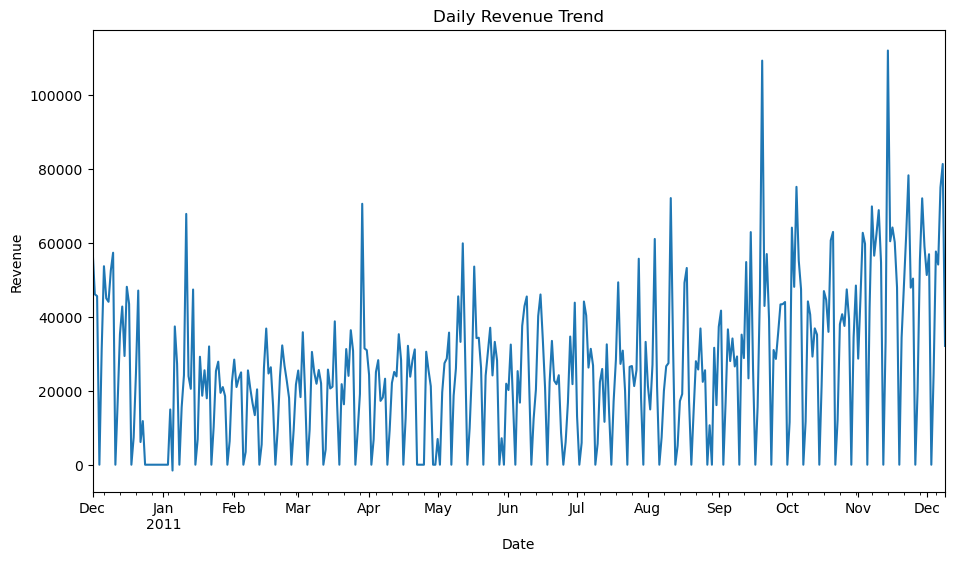

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime is sorted
df_clean = df_clean.sort_values('InvoiceDate')

# Daily sales trend
daily_sales = df_clean.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()

plt.figure(figsize=(11,6))
daily_sales.plot()
plt.title('Daily Revenue Trend')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()




Monthly Sales Trend

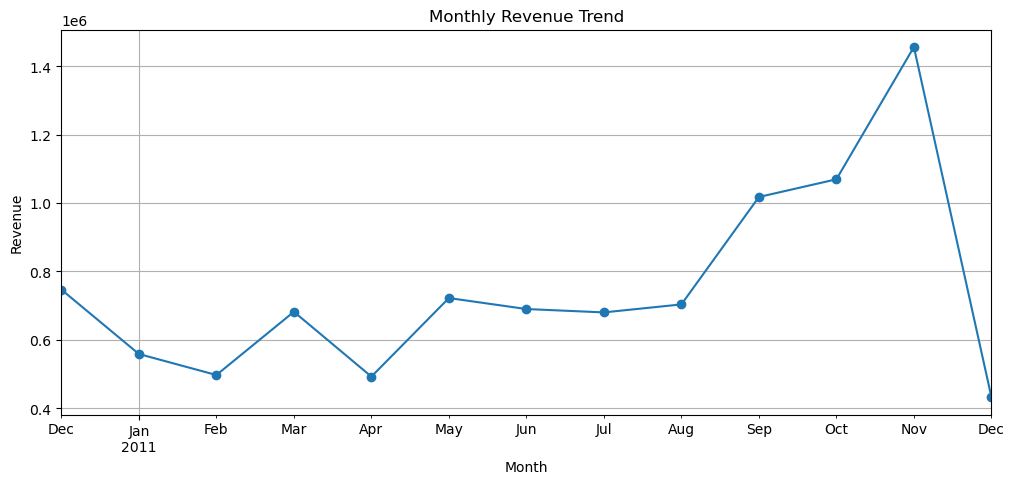

count    1.300000e+01
mean     7.498562e+05
std      2.822587e+05
min      4.327011e+05
25%      5.584486e+05
50%      6.899772e+05
75%      7.467236e+05
max      1.456146e+06
Name: TotalPrice, dtype: float64

In [83]:
monthly_sales = df_clean.set_index('InvoiceDate').resample('ME')['TotalPrice'].sum()

plt.figure(figsize=(12,5))
monthly_sales.plot(marker='o')
plt.title('Monthly Revenue Trend')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.grid(True)
plt.show()

monthly_sales.describe()


Weekly Trend

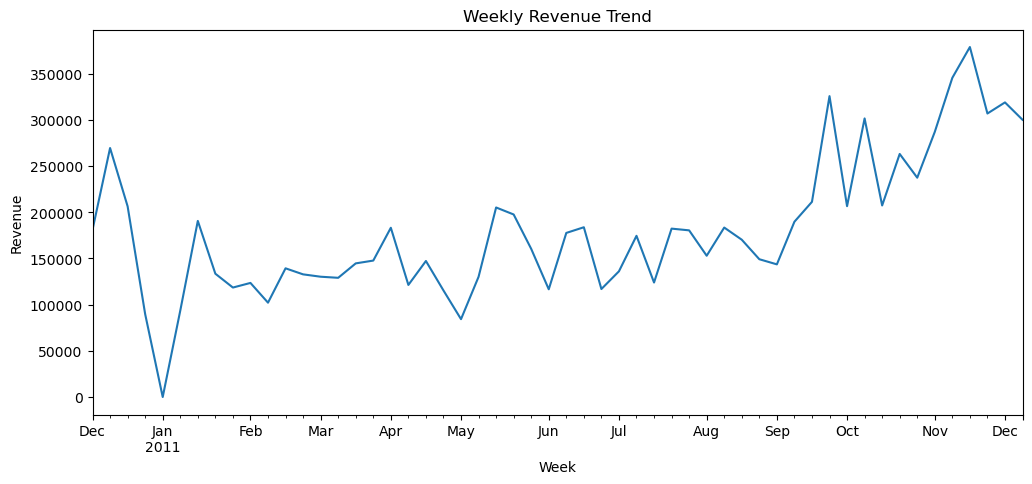

In [85]:
weekly_sales = df_clean.set_index('InvoiceDate').resample('W')['TotalPrice'].sum()

plt.figure(figsize=(12,5))
weekly_sales.plot()
plt.title('Weekly Revenue Trend')
plt.ylabel('Revenue')
plt.xlabel('Week')
plt.show()


Day of Week & Hourly Patterns

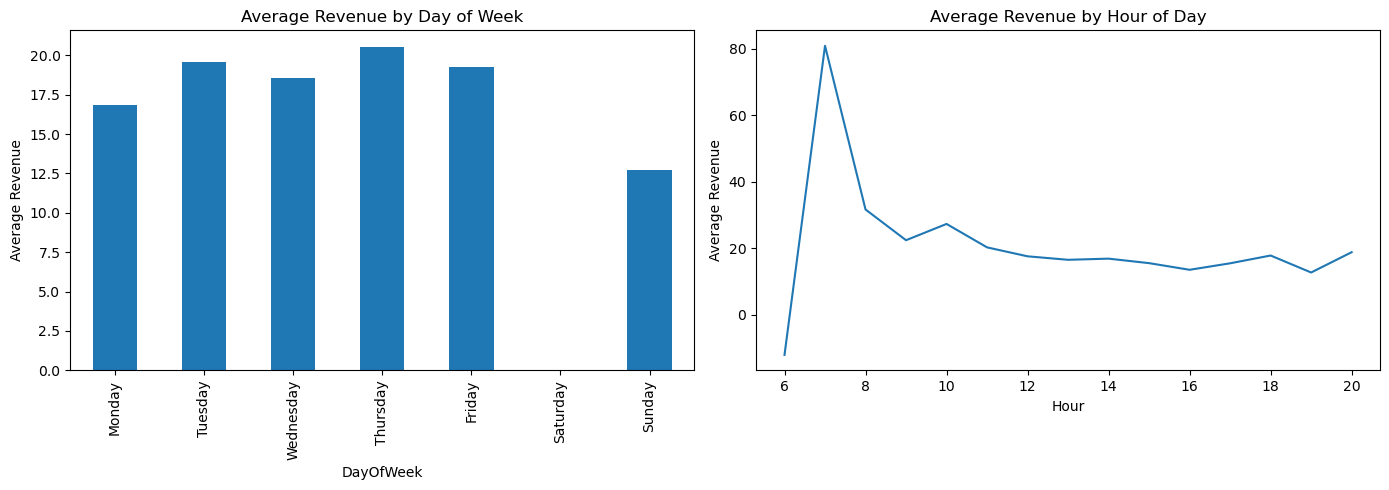

In [86]:
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# Average revenue by day of week
dow_sales = df_clean.groupby('DayOfWeek')['TotalPrice'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

# Average revenue by hour
hour_sales = df_clean.groupby('Hour')['TotalPrice'].mean()

# Plot
fig, ax = plt.subplots(1,2, figsize=(14,5))

dow_sales.plot(kind='bar', ax=ax[0])
ax[0].set_title('Average Revenue by Day of Week')
ax[0].set_ylabel('Average Revenue')

hour_sales.plot(kind='line', ax=ax[1])
ax[1].set_title('Average Revenue by Hour of Day')
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Average Revenue')

plt.tight_layout()
plt.show()


Rolling Averages

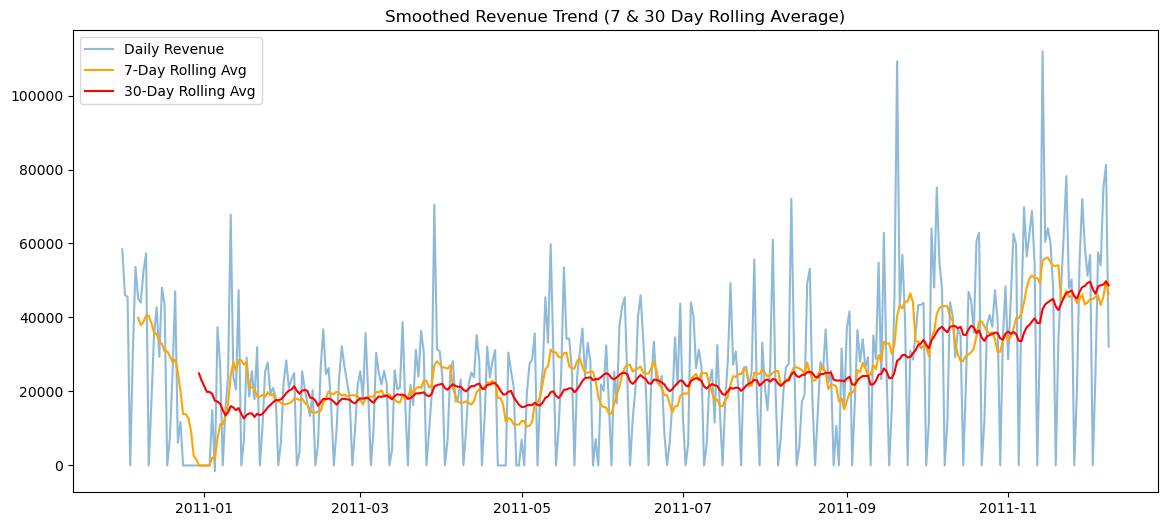

In [87]:
rolling_7d = daily_sales.rolling(window=7).mean()   # 7-day moving average
rolling_30d = daily_sales.rolling(window=30).mean() # 30-day moving average

plt.figure(figsize=(14,6))
plt.plot(daily_sales, alpha=0.5, label='Daily Revenue')
plt.plot(rolling_7d, color='orange', label='7-Day Rolling Avg')
plt.plot(rolling_30d, color='red', label='30-Day Rolling Avg')
plt.title('Smoothed Revenue Trend (7 & 30 Day Rolling Average)')
plt.legend()
plt.show()


Understanding RFM Analysis

In [88]:
# Filter customers with valid IDs
df_rfm = df_clean[df_clean['CustomerID'].notnull()].copy()

# Verify data range
print(df_rfm['InvoiceDate'].min(), df_rfm['InvoiceDate'].max())


2010-12-01 08:26:00 2011-12-09 12:50:00


In [89]:
import datetime as dt

# Reference date - usually one day after the last transaction
reference_date = df_rfm['InvoiceDate'].max() + dt.timedelta(days=1)
reference_date


Timestamp('2011-12-10 12:50:00')

In [90]:
rfm = df_rfm.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,-1,1,1610,1469611.65
1,12346,326,2,0.00
2,12347,2,7,4310.00
3,12348,75,4,1797.24
4,12349,19,1,1757.55


Rank and Score Each Metric (1-5)

In [91]:
rfm['R_rank'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_rank'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm['R_rank'].astype(str) + rfm['F_rank'].astype(str) + rfm['M_rank'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
0,-1,1,1610,1469611.65,5,5,5,555
1,12346,326,2,0.00,1,2,1,121
2,12347,2,7,4310.00,5,4,5,545
3,12348,75,4,1797.24,2,3,4,234
4,12349,19,1,1757.55,4,1,4,414


Create RFM Segments

In [92]:
def segment(x):
    r, f, m = int(x['R_rank']), int(x['F_rank']), int(x['M_rank'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'Recent Customers'
    elif f >= 4 and m >= 3:
        return 'Big Spenders'
    elif r <= 2 and f <= 2:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment, axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score,Segment
0,-1,1,1610,1469611.65,5,5,5,555,Champions
1,12346,326,2,0.00,1,2,1,121,At Risk
2,12347,2,7,4310.00,5,4,5,545,Champions
3,12348,75,4,1797.24,2,3,4,234,Others
4,12349,19,1,1757.55,4,1,4,414,Recent Customers


In [93]:
# Analyze Segments

segment_summary = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'CustomerID': 'Count'}).sort_values('Monetary', ascending=False)

segment_summary


,Count,Recency,Frequency,Monetary
Segment,,,,
Champions,975,11.967179,15.005128,7289.703077
Big Spenders,253,132.055336,6.079051,1882.030119
Loyal Customers,971,32.580844,4.410917,1244.084151
Others,786,114.996183,2.068702,538.832763
Recent Customers,329,17.437690,1.358663,413.094529
At Risk,1058,216.993384,1.202268,375.312468


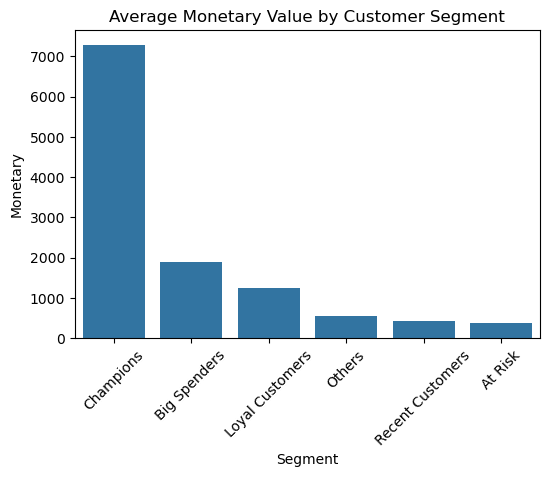

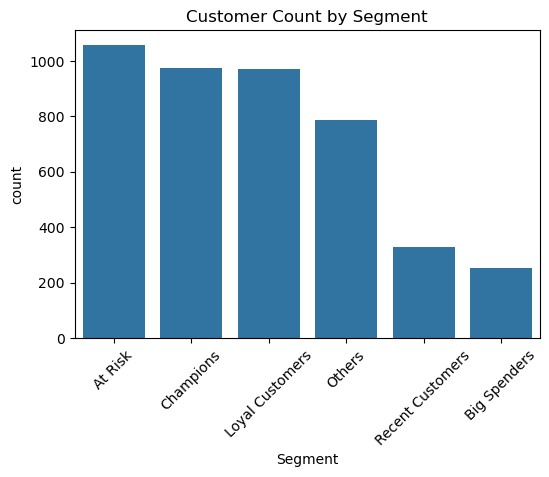

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(data=segment_summary.reset_index(), x='Segment', y='Monetary')
plt.title('Average Monetary Value by Customer Segment')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Count by Segment')
plt.xticks(rotation=45)
plt.show()


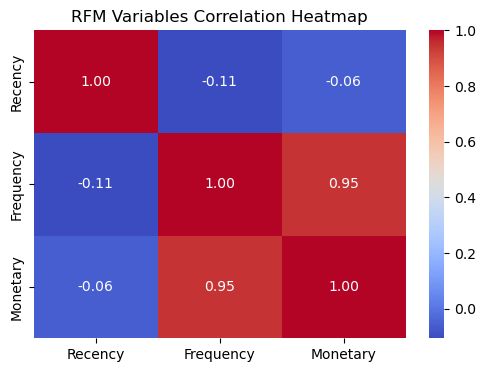

In [96]:


plt.figure(figsize=(6,4))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('RFM Variables Correlation Heatmap')
plt.show()


RFM Distribution Visualization

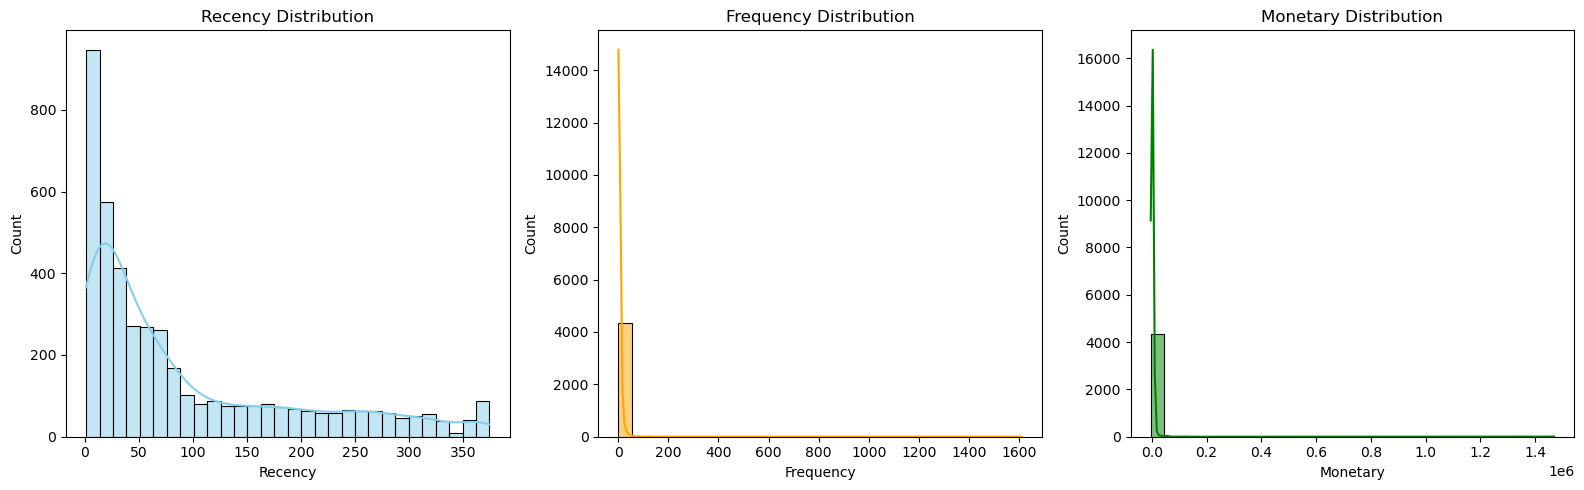

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
sns.histplot(rfm['Recency'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


Product Performance Analysis

C:\Users\royav\AppData\Local\Temp\ipykernel_1552\115553938.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products_revenue, x='TotalPrice', y='Description', palette='viridis')


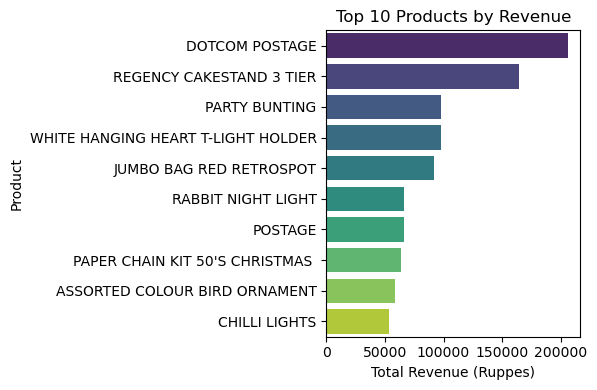

,StockCode,Description,TotalPrice
0,DOT,DOTCOM POSTAGE,206245.48
1,22423,REGENCY CAKESTAND 3 TIER,164459.49
2,47566,PARTY BUNTING,98243.88
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,97659.94
4,85099B,JUMBO BAG RED RETROSPOT,92175.79
5,23084,RABBIT NIGHT LIGHT,66661.63
6,POST,POSTAGE,66230.64
7,22086,PAPER CHAIN KIT 50'S CHRISTMAS,63715.24
8,84879,ASSORTED COLOUR BIRD ORNAMENT,58792.42
9,79321,CHILLI LIGHTS,53746.66


In [99]:
top_products_revenue = (
    df_clean.groupby(['StockCode', 'Description'])['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(data=top_products_revenue, x='TotalPrice', y='Description', palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue (Ruppes)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

top_products_revenue


Top Products by Quantity Sold

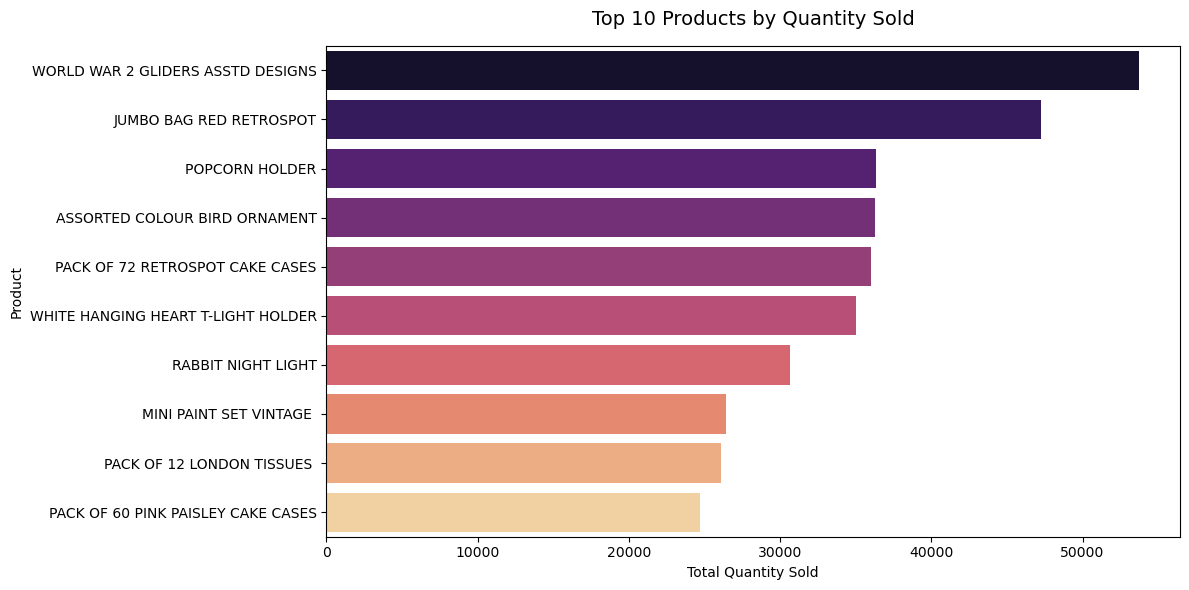

In [106]:
top_products_qty = (
    df_clean.groupby(['StockCode', 'Description'])['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_products_qty,
    x='Quantity',
    y='Description',
    hue='Description',
    palette='magma',
    order=top_products_qty.sort_values('Quantity', ascending=False)['Description'],
    dodge=False,
    legend=False
)
plt.title('Top 10 Products by Quantity Sold', fontsize=14, pad=15)
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

Product Performance by Country

In [113]:
country_product = (
    df_clean.groupby(['Country', 'StockCode'])['TotalPrice']
    .sum()
    .reset_index()
)

top_country_products = (
    country_product.groupby('Country')
    .apply(lambda x: x.sort_values('TotalPrice', ascending=False).head(3))
    .reset_index(drop=True)
)

top_country_products.head(10)


C:\Users\royav\AppData\Local\Temp\ipykernel_1552\4165020167.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('TotalPrice', ascending=False).head(3))


,Country,StockCode,TotalPrice
0,Australia,23084,3375.84
1,Australia,22722,2082.00
2,Australia,21731,1987.20
3,Austria,POST,1456.00
4,Austria,22584,302.40
5,Austria,22582,302.40
6,Bahrain,23076,120.00
7,Bahrain,23077,75.00
8,Bahrain,22890,59.70
9,Belgium,POST,4248.00
